<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/20220426_hj_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

from matplotlib import pyplot as plt

In [3]:
train_cases = sorted(glob('/content/drive/MyDrive/KIST/open/train/*'))

CASE02_01.png
leaf_weight : 194.662


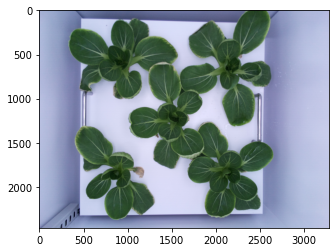

CASE02_02.png
leaf_weight : 198.366


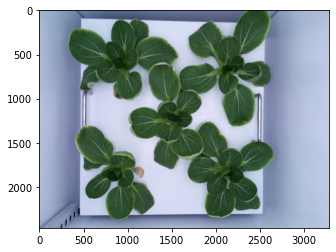

CASE02_03.png
leaf_weight : 196.788


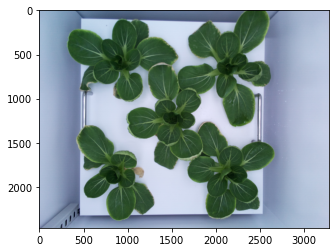

CASE02_04.png
leaf_weight : 197.342


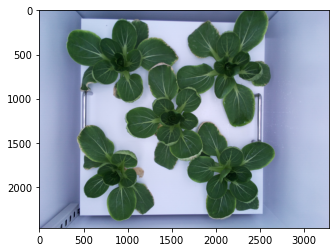

CASE02_05.png
leaf_weight : 200.202


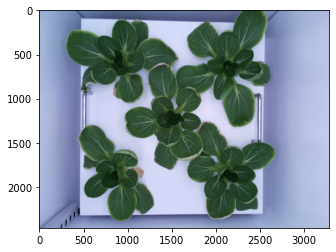

CASE02_06.png
leaf_weight : 201.48


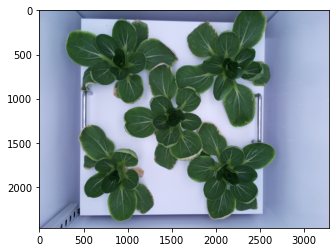

CASE02_07.png
leaf_weight : 197.409


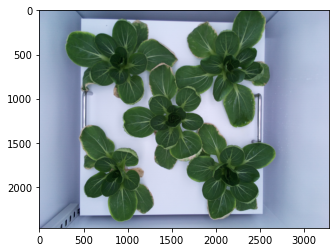

CASE02_08.png
leaf_weight : 185.996


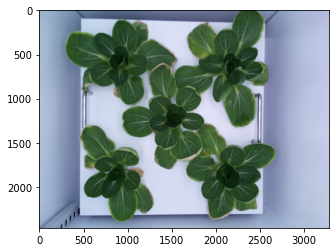

CASE02_09.png
leaf_weight : 165.73


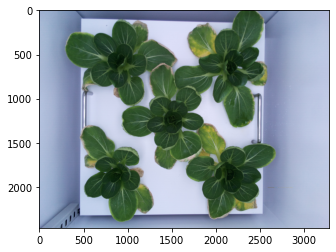

CASE02_10.png
leaf_weight : 153.971


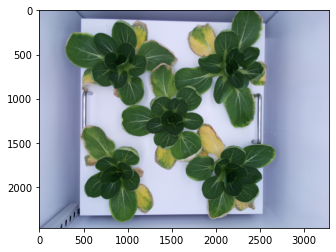

CASE02_11.png
leaf_weight : 142.744


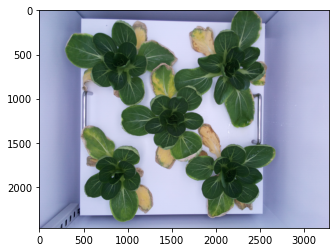

In [4]:
images = glob(train_cases[1]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[1]+'/label.csv')
for i in range(len(images)):
  image = cv2.imread(images[i])
  print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
metas = glob(train_cases[1]+'/meta/*')
metas_df = pd.concat(map(pd.read_csv, metas), ignore_index=True)

In [6]:
metas_df

,시간,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-05-18 02:46,18.1,76.699997,83.699997,0.0,623.0,18.299999,0.0,201.0,201.0,201.0,14.0,0.0,15.0,20.500002,0.0,0.0,0.0,NaN
1,2021-05-18 02:47,18.1,76.699997,83.699997,0.0,623.0,18.299999,0.0,201.0,201.0,0.0,14.0,0.0,15.0,20.500002,0.0,0.0,0.0,NaN
2,2021-05-18 02:48,18.1,76.699997,83.699997,0.0,623.0,18.400000,0.0,201.0,201.0,0.0,14.0,0.0,15.0,20.500002,0.0,0.0,0.0,NaN
3,2021-05-18 02:49,18.1,76.699997,83.699997,NaN,626.0,18.299999,0.0,201.0,201.0,NaN,14.0,0.0,15.0,20.500002,0.0,0.0,0.0,NaN
4,2021-05-18 02:50,18.1,76.699997,83.900002,0.0,628.0,18.299999,0.0,201.0,201.0,0.0,14.0,0.0,15.0,20.500002,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,2021-05-29 02:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15836,2021-05-29 02:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15837,2021-05-29 02:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15838,2021-05-29 02:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
metas_df['화이트 LED동작강도'].unique()

array([201.,   0.,  nan,   1.])

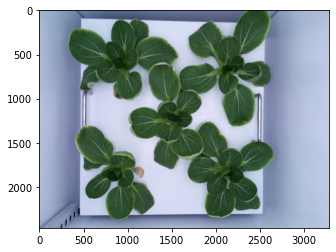

In [10]:
image_1 = cv2.imread(images[1])
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [12]:
import urllib
url, filename = ("/content/drive/MyDrive/KIST/open/train/CASE01/image/CASE01_01.png", "CASE01_01.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

ValueError: ignored

In [17]:
# 샘플을 실행합니다. (torchvision이 필요합니다.)
from PIL import Image
from torchvision import transforms
input_image = Image.open('/content/drive/MyDrive/KIST/open/train/CASE01/image/CASE01_07.png')
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # 모델이 원하는 미니 배치를 만듭니다.

# 가능한 경우 속도를 빠르게 하기 위해 입력 및 모델을 GPU로 이동합니다.
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

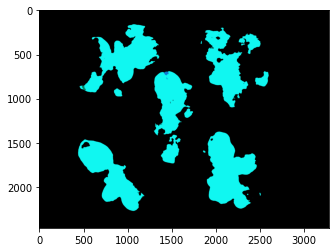

In [18]:
# 색상 팔레트를 만들고 각 클래스의 색상을 선택합니다.
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# 각 색상에서 21개 클래스의 의미론적 분할 예측을 플로팅합니다.
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

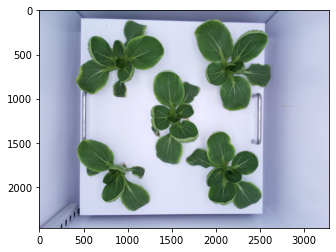

In [6]:
image_1 = cv2.imread('/content/drive/MyDrive/KIST/open/train/CASE01/image/CASE01_07.png')
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.3 MB 16.4 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 


In [51]:
# 자신의 폴더 경로에 맞게 재지정해주세요.
root_path = '/content/drive/MyDrive/KIST/open/'
data_dir = root_path

# data_dir의 경로(문자열)와 train(문자열)을 결합해서 train_dir(train 폴더의 경로)에 저장합니다.
train_dir = glob(os.path.join(data_dir, 'train/*/image/*'))

# data_dir의 경로(문자열)와 val(문자열)을 결합해서 val_dir(val 폴더의 경로)에 저장합니다.
test_dir = glob(os.path.join(data_dir, 'test/image/*'))

# # train_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 train_fns에 저장합니다.
# train_fns = os.listdir(train_dir)

# # val_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 val_fns에 저장합니다.
# test_fns = os.listdir(test_dir)

print(len(train_dir), len(test_dir))

1592 460


In [53]:
from PIL import Image

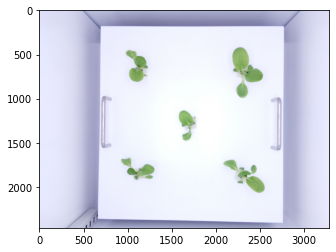

In [54]:
# train_dir(문자열)와 train_fns[0](문자열)의 경로를 결합하여 sample_image_fp(샘플 이미지의 경로)에 저장합니다.
sample_image_fp = train_dir[0]

# PIL 라이브러리의 Image 모듈을 사용하여, sample_image_fp를 불러옵니다.
# RGB 형태로 변환하여 sample_image에 저장하는 것으로 이해했는데, ".convert("RGB")" 코드는 없어도 될 것 같습니다.
# Image.open() 함수 자체가 RGB의 형태로 불러오는 것으로 이해했습니다. 확실하지 않습니다...
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [55]:
num_items = 1000

# 0~255 사이의 숫자를 3*num_items번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [58]:
pip install sklearn

In [62]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++')

In [64]:
num_classes = 10

# K-means clustering 알고리즘을 사용하여 label_model에 저장합니다.
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [65]:
# 이전에 샘플이미지에서 볼 수 있듯이, original image와 labeled image가 연결되어 있는데 이를 분리해줍니다.
def split_image(image) :
   image = np.array(image)
   
   # 이미지의 크기가 256 x 512 였는데 이를 original image와 labeled image로 분리하기 위해 리스트로 슬라이싱 합니다.
   # 그리고 분리된 이미지를 각각 cityscape(= original image)와 label(= labeled image)에 저장합니다.
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

In [66]:
# 바로 이전 코드에서 정의한 split_image() 함수를 이용하여 sample_image를 분리한 후, cityscape과 label에 각각 저장합니다.
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

ValueError: ignored